In [1]:
#подключим диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# импортируем библиотеки
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
#сравним с готовым детектором
#!pip install  mtcnn 
#from mtcnn import MTCNN

In [4]:
#вытягивает фрейм из потока вебкамеры
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [5]:
#делаем снимок и сохраняем на диск
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  

  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to /content/sample_data/photo0.jpg


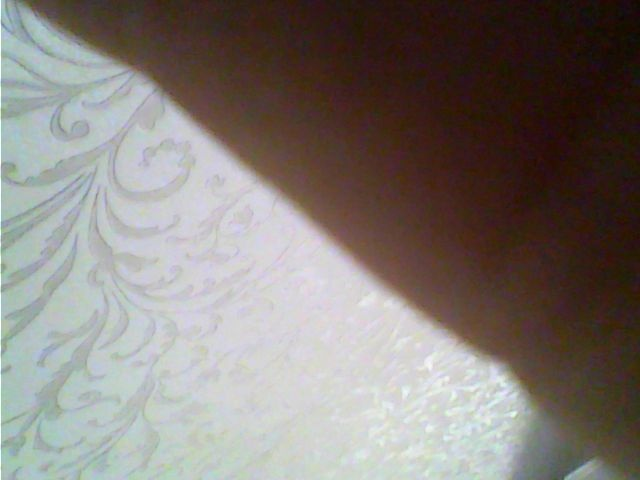

In [7]:
#сделаем снимок
try:
  filename = take_photo('/content/sample_data/photo0.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [8]:
#настройки видео с камеры
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [9]:
#функция для создания триплетов, ожидает что переменные
# img1, img2, img3 существуют и не пусты
def mix_frame(new_img):
    """конкатинирует 3 кадра в одну картинку, не ищет лицо"""
    global img1 
    global img2
    global img3
    #global save_path

    img3 = img2
    img2 = img1
    img1 = new_img
    
    img0 = np.empty((new_img.shape[0],new_img.shape[1],3))

    imgGray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    imgGray1 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    imgGray2 = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)
 
    
    img0[:,:,0] = imgGray
    img0[:,:,1] = imgGray1
    img0[:,:,2] = imgGray2
    
    #cv2.imwrite(save_path, img0)
    return img0

In [10]:
#создадим перременные для предыдущей функции
img1 = cv2.imread('/content/sample_data/photo0.jpg')
img2 = cv2.imread('/content/sample_data/photo1.jpg')
img3 = cv2.imread('/content/sample_data/photo2.jpg')
save_path = '/content/sample_data/'

In [11]:
#new_img = cv2.imread('/content/sample_data/photo0.jpg')
#mix_img = mix_frame(new_img)
#cv2_imshow(mix_img)

In [12]:
#https://drive.google.com/file/d/1_73YrfQzw517fqdvPnqV-85b4GITsclv/view?usp=sharing
#https://drive.google.com/file/d/1FIULVcedThLU2jKpm_jfxOO4CAcN-6eX/view?usp=sharing

In [13]:
#подгрузим модель отличающую человека от фото
url = ['1FIULVcedThLU2jKpm_jfxOO4CAcN-6eX']
name=['test13.hdf5',]
import gdown
#!mkdir feature_trends

for i in range(len(url)):
    output = "/content/sample_data/"+name[i]
    print('https://drive.google.com/uc?export=download&id='+url[i])
    gdown.download('https://drive.google.com/uc?export=download&id='+url[i], output, quiet=False)

https://drive.google.com/uc?export=download&id=1FIULVcedThLU2jKpm_jfxOO4CAcN-6eX


Downloading...
From: https://drive.google.com/uc?export=download&id=1FIULVcedThLU2jKpm_jfxOO4CAcN-6eX
To: /content/sample_data/test13.hdf5
100%|██████████| 257M/257M [00:01<00:00, 226MB/s]


In [14]:
import numpy as np
import pandas as pd
import sys
import os
import math


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

CLASS_NUM            = 3  # test2 -1000
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
LR                   = 0.00002

In [15]:
#Строим модель отличающую человека от фото test 13
#Загружаем предобученную сеть Xception:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

#base_model.trainable = False
#base_model.summary()
#Устанавливаем новую «голову» (head):
x = base_model.output
x = GlobalAveragePooling2D()(x)  #Pooling слой
x = BatchNormalization()(x) #добавим Batch нормализацию
x = Dense(256, activation='elu')(x) # полносвязный слой с активацией elu
x = Dropout(0.25)(x) # полносвязный слой с вероятность отключения нейронов в слое
predictions = Dense(CLASS_NUM, activation='softmax')(x) #логистический слой c 3 классами


model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
#восстановим веса
#model.load_weights('/content/sample_data/test12.hdf5')
model.load_weights('/content/sample_data/test13.hdf5')

In [17]:
#протестируем
mix_img = cv2.imread('/content/drive/MyDrive/face/p0 (10).png')

image = cv2.imread('/content/drive/MyDrive/face/m0 (7).png')[..., ::-1]
image3 = cv2.resize(image, (224, 224))/255
pred = model.predict(image3[None, ...])
print(pred)
predictions = np.argmax(pred, axis=-1)
print(predictions)

[[0.48336816 0.4029175  0.11371434]]
[0]


In [18]:
mix_img
image = mix_img[..., ::-1]
image3 = cv2.resize(image, (224, 224))/255
pred = model.predict(image3[None, ...])
print(pred)
predictions = np.argmax(pred, axis=-1)
print(predictions)

[[0.5351757  0.2768062  0.18801814]]
[0]


In [19]:
#функция детектор принимает кадр, возвращает решение модели
num_detect = 0
def my_detector(frame):

  global num_detect

  mix_img = mix_frame(frame)

  num_detect += 1
 # cv2.imwrite('/content/drive/MyDrive/kkkk/'+str(num_detect)+'p.jpg', mix_img) #сохранение триплетов

  mix_img
  image = mix_img[..., ::-1]
  image3 = cv2.resize(image, (224, 224))/255
  pred = model.predict(image3[None, ...])
  
  return pred




In [20]:
#тестовые изображения
new_img = cv2.imread('/content/sample_data/photo0.jpg')
#new_img1 = cv2.imread('/content/sample_data/photoN.jpg')
my_detector(new_img)

array([[0.94582146, 0.01074589, 0.04343259]], dtype=float32)

In [21]:
#детектор лиц для сравнения
#detector = MTCNN()
#detector.detect_faces(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

In [22]:
# my_retina######################################################
# восстанавливаем мой обученный детектор

In [23]:
import sys
sys.path.append('/content/drive/MyDrive/retinaface/my_retina1')

In [24]:
from retina_unit1 import *

In [25]:
import os
import zipfile
from dataclasses import dataclass

from absl import logging
import tqdm
import random
import tensorflow as tf
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt

import yaml
import sys
import time

from tensorflow.keras.utils import plot_model

import copy

import numpy as np

%matplotlib inline

In [ ]:
#поместим чекпоинт в паку где модель ожидает его найти
os.mkdir("./checkpoints")
os.mkdir("./checkpoints/retinaface_res50")

In [27]:
import shutil
shutil.copy(
    os.path.join('/content/drive/MyDrive/retinaface/my_retina1/', 'checkpoint'),
    os.path.join('/content/checkpoints/retinaface_res50/')
)
import shutil
shutil.copy(
    os.path.join('/content/drive/MyDrive/retinaface/my_retina1/', 'ckpt-11.index'),
    os.path.join('/content/checkpoints/retinaface_res50/')
)
import shutil
shutil.copy(
    os.path.join('/content/drive/MyDrive/retinaface/my_retina1/', 'ckpt-11.data-00000-of-00001'),
    os.path.join('/content/checkpoints/retinaface_res50/')
)


'/content/checkpoints/retinaface_res50/ckpt-11.data-00000-of-00001'

In [28]:
# Зададим настройки модели
BATCH_SIZE = 12 
EPOCHS = 1

## Настройки конфигов обучения
MODELS_CONFIG = {
    'ResNet50': {
        'cfg_path': f'../input/configresnet/retinaface_res50.yaml',
        'dataset_path': f'../input/widerface/widerface_train_bin.tfrecord',
        'batch_size': BATCH_SIZE,
        'testing_dataset_path': f'../input/widerface/val',
        'epoch': EPOCHS
    }
}

# Выберем backbone для RetinaFace
backbone_model = 'ResNet50'

dataset_path = MODELS_CONFIG[backbone_model]['dataset_path']
cfg_path = MODELS_CONFIG[backbone_model]['cfg_path']
batch_size = MODELS_CONFIG[backbone_model]['batch_size'] 
testing_dataset_path = MODELS_CONFIG[backbone_model]['testing_dataset_path']
epoch = MODELS_CONFIG[backbone_model]['epoch']

custom_config_path = f'/content/drive/MyDrive/retinaface/my_retina1/retinaface_res50.yaml'

In [29]:
retina_detector = RetinaFace(custom_config_path)

94781440/94765736 [==============================] - 1s 0us/step


In [30]:
retina_detector.is_fitted = True

In [31]:
y_pred = retina_detector.predict(new_img)

In [32]:
#протестируем
y_pred

{'image_params': [(640, 480)],
 'outputs': [array([], shape=(0, 16), dtype=float32)]}

In [33]:
#len(y_pred['outputs'][0])

In [ ]:
height = y_pred['image_params'][0][1]
width = y_pred['image_params'][0][0]
x0 = round(y_pred['outputs'][0][0][0]*width)
y0 = round(y_pred['outputs'][0][0][1]*height)
x1 = round(y_pred['outputs'][0][0][2]*width)
y1 = round(y_pred['outputs'][0][0][3]*height)


In [ ]:
image = cv2.rectangle(new_img,
              (x0, y0), (x1, y1),
              (0,155,255),
              2)

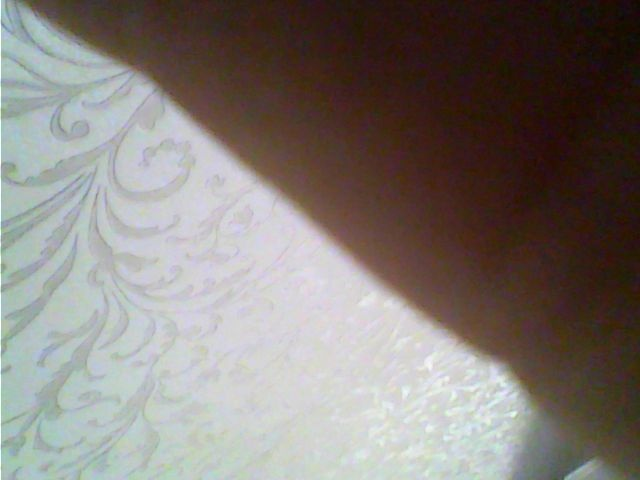

In [34]:
cv2_imshow(new_img)

In [ ]:
###############################################################

In [ ]:
#cv2_imshow(mix_img)

In [ ]:
#cv2.imwrite('/content/drive/MyDrive/kkkk/photo6.jpg', mix_img)

In [ ]:
#np.argmax(pred)

In [ ]:
#new_img = cv2.imread('/content/sample_data/photo0.jpg')
#my_detector(new_img)

array([[0.45578602, 0.00260434, 0.5416097 ]], dtype=float32)

### Запускаем все модели с вебкамерой

In [35]:
#detector = MTCNN()
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    #detections, width_ratio, height_ratio = darknet_helper(frame, width, height)
    my_class = my_detector(frame)
    
    
    

    # loop through detections and draw them on transparent overlay image

    if np.argmax(my_class, axis=-1) == 0:
      bbox_array = cv2.rectangle(bbox_array, (10, 10), (630, 470), (168,168,20) , 10)
    elif my_class[0,2] > 0.23 or my_class[0,1] < 0.77:
      bbox_array = cv2.rectangle(bbox_array, (10, 10), (630, 470), (168,20,20) , 10)
    else:
      bbox_array = cv2.rectangle(bbox_array, (10, 10), (630, 470), (20,168,20) , 10)


    # MTCNN()
    '''
    face = detector.detect_faces(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if len(face) > 0:
      bounding_box = face[0]['box']
      bbox_array = cv2.rectangle(bbox_array,(bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255), 2)
    '''
    #MTCNN()
    #my_retina
    face = retina_detector.predict(frame)
    if len(face['outputs'][0]) > 0:
      height = face['image_params'][0][1]
      width = face['image_params'][0][0]
      x0 = round(face['outputs'][0][0][0]*width)
      y0 = round(face['outputs'][0][0][1]*height)
      x1 = round(face['outputs'][0][0][2]*width)
      y1 = round(face['outputs'][0][0][3]*height)

      bbox_array = cv2.rectangle(bbox_array,(x0, y0), (x1, y1),  (0,155,255), 2)

    #my_retina


    bbox_array = cv2.putText(bbox_array,
                             "{:.2f}".format(float(my_class[0,0])),
                             (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                             (0,0,20),
                              2)  
    bbox_array = cv2.putText(bbox_array,
                             "{:.2f}".format(float(my_class[0,1])),
                             (70, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                             (0,0,20),
                              2)
    bbox_array = cv2.putText(bbox_array,
                             "{:.2f}".format(float(my_class[0,2])),
                             (110, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                             (0,0,20),
                              2)    

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

In [ ]:
bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

In [ ]:

LR

2e-05

In [ ]:
my_class[0,2]

0.20957151

In [ ]:
my_class = my_detector(frame)